# Generating Graphs using Graph Neural Networks

In [273]:
import torch
!pip install -q torch-scatter~=2.1.0 torch-sparse~=0.6.16 torch-cluster~=1.6.0 torch-spline-conv~=1.2.1 torch-geometric==2.2.0 -f https://data.pyg.org/whl/torch-{torch.__version__}.html
!pip install -q deepchem==2.7.1

torch.manual_seed(0)
torch.cuda.manual_seed(0)
torch.cuda.manual_seed_all(0)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

## Traditional techniques

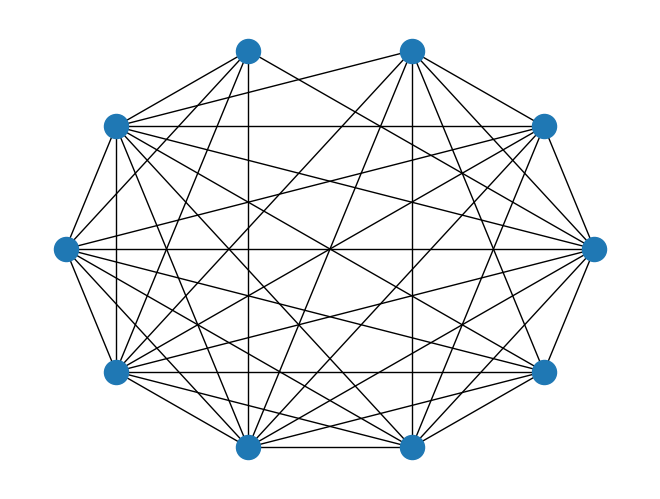

In [274]:
import networkx as nx
import matplotlib.pyplot as plt

G = nx.erdos_renyi_graph(10, 0.9, seed=0)
pos = nx.circular_layout(G) 
nx.draw(G, pos=pos)

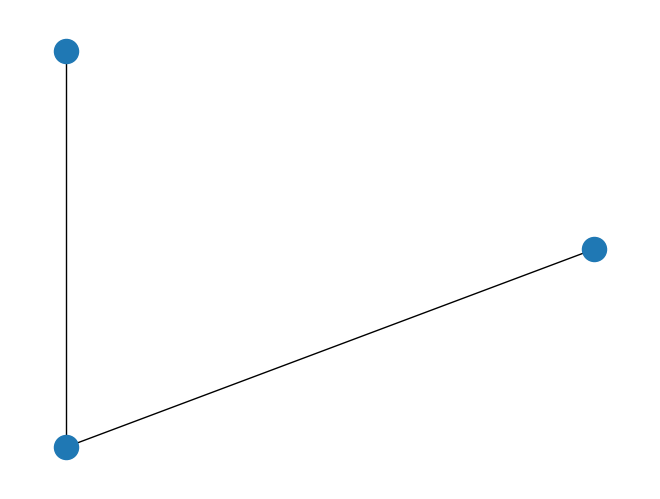

In [275]:
G = nx.gnm_random_graph(3, 2, seed=3)
pos = nx.circular_layout(G) 
nx.draw(G, pos=pos)

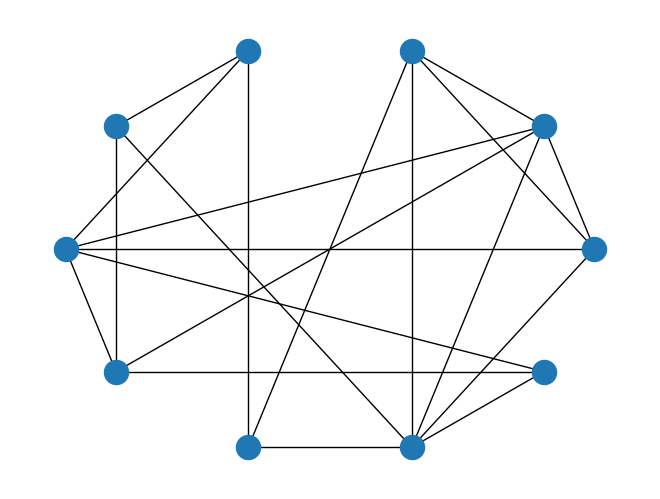

In [276]:
G = nx.watts_strogatz_graph(10, 4, 0.5, seed=0)
pos = nx.circular_layout(G) 
nx.draw(G, pos=pos)

## Graph Variational Autoencoders (GVAE)

In [277]:
import torch
import torch_geometric.transforms as T
from torch_geometric.datasets import Planetoid

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

transform = T.Compose([
    T.NormalizeFeatures(),
    T.ToDevice(device),
    T.RandomLinkSplit(num_val=0.05, num_test=0.1, is_undirected=True, split_labels=True, add_negative_train_samples=False),
])

dataset = Planetoid('.', name='Cora', transform=transform)

train_data, val_data, test_data = dataset[0]

In [278]:
from torch_geometric.nn import GCNConv, VGAE

class Encoder(torch.nn.Module):
    def __init__(self, dim_in, dim_out):
        super().__init__()
        self.conv1 = GCNConv(dim_in, 2 * dim_out)
        self.conv_mu = GCNConv(2 * dim_out, dim_out)
        self.conv_logstd = GCNConv(2 * dim_out, dim_out)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index).relu()
        return self.conv_mu(x, edge_index), self.conv_logstd(x, edge_index)

model = VGAE(Encoder(dataset.num_features, 16)).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

def train():
    model.train()
    optimizer.zero_grad()
    z = model.encode(train_data.x, train_data.edge_index)
    loss = model.recon_loss(z, train_data.pos_edge_label_index) + (1 / train_data.num_nodes) * model.kl_loss()
    loss.backward()
    optimizer.step()
    return float(loss)

@torch.no_grad()
def test(data):
    model.eval()
    z = model.encode(data.x, data.edge_index)
    return model.test(z, data.pos_edge_label_index, data.neg_edge_label_index)

for epoch in range(301):
    loss = train()
    val_auc, val_ap = test(val_data)
    if epoch % 50 == 0:
        print(f'Epoch: {epoch:>3} | Val AUC: {val_auc:.4f} | Val AP: {val_ap:.4f}')

val_auc, val_ap = test(val_data)
print(f'\nTest AUC: {val_auc:.4f} | Test AP: {val_ap:.4f}')

Epoch:   0 | Val AUC: 0.6806 | Val AP: 0.7086
Epoch:  50 | Val AUC: 0.6828 | Val AP: 0.7075
Epoch: 100 | Val AUC: 0.7499 | Val AP: 0.7558
Epoch: 150 | Val AUC: 0.7611 | Val AP: 0.7741
Epoch: 200 | Val AUC: 0.8365 | Val AP: 0.8329
Epoch: 250 | Val AUC: 0.8853 | Val AP: 0.8915
Epoch: 300 | Val AUC: 0.8869 | Val AP: 0.8925

Test AUC: 0.8869 | Test AP: 0.8925


In [279]:
z = model.encode(test_data.x, test_data.edge_index)
adj = torch.where((z @ z.T) > 0.9, 1, 0)
adj

tensor([[1, 0, 0,  ..., 0, 1, 1],
        [0, 1, 1,  ..., 0, 0, 0],
        [0, 1, 1,  ..., 0, 1, 1],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [1, 0, 1,  ..., 0, 1, 1],
        [1, 0, 1,  ..., 0, 1, 1]], device='cuda:0')

## MolGAN

In [301]:
import pandas as pd
import numpy as np
from tensorflow import one_hot

import deepchem as dc
from deepchem.models.optimizers import ExponentialDecay
from deepchem.models import BasicMolGANModel as MolGAN
from deepchem.feat.molecule_featurizers.molgan_featurizer import GraphMatrix

from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem import rdmolfiles
from rdkit.Chem import rdmolops
from rdkit.Chem.Draw import IPythonConsole

In [302]:
_, datasets, _ = dc.molnet.load_tox21()
df = pd.DataFrame(datasets[0].ids, columns=['smiles'])
df

,smiles
0,CC(O)(P(=O)(O)O)P(=O)(O)O
1,CC(C)(C)OOC(C)(C)CCC(C)(C)OOC(C)(C)C
2,OC[C@H](O)[C@@H](O)[C@H](O)CO
3,CCCCCCCC(=O)[O-].CCCCCCCC(=O)[O-].[Zn+2]
4,CC(C)COC(=O)C(C)C
...,...
6259,CC1CCCCN1CCCOC(=O)c1ccc(OC2CCCCC2)cc1
6260,Cc1cc(CCCOc2c(C)cc(-c3noc(C(F)(F)F)n3)cc2C)on1
6261,O=C1OC(OC(=O)c2cccnc2Nc2cccc(C(F)(F)F)c2)c2ccc...
6262,CC(=O)C1(C)CC2=C(CCCC2(C)C)CC1C


In [303]:
max_atom = 15

featurizer = dc.feat.MolGanFeaturizer(max_atom_count=max_atom)
molecules = [x for x in df['smiles'].values if Chem.MolFromSmiles(x).GetNumAtoms() < max_atom]

features = []
for x in molecules:
    mol = Chem.MolFromSmiles(x)
    new_order = rdmolfiles.CanonicalRankAtoms(mol)
    mol = rdmolops.RenumberAtoms(mol, new_order)
    feature = featurizer.featurize(mol)
    if feature.size != 0:
        features.append(feature[0])

[23:33:22] WARNING: not removing hydrogen atom without neighbors
Failed to featurize datapoint 0, CC(O)(P(=O)(O)O)P(=O)(O)O. Appending empty array
Exception message: 15
Failed to featurize datapoint 0, CCCCNC(=S)NCCCC. Appending empty array
Exception message: 16
Failed to featurize datapoint 0, O=[N+]([O-])[O-].O=[N+]([O-])[O-].[Ca+2]. Appending empty array
Exception message: 20
Failed to featurize datapoint 0, CC(C)CCCCCOC(=O)CCS. Appending empty array
Exception message: 16
[23:33:22] WARNING: not removing hydrogen atom without neighbors
Failed to featurize datapoint 0, F[B-](F)(F)F.[H+]. Appending empty array
Exception message: 5
Failed to featurize datapoint 0, [I-].[K+]. Appending empty array
Exception message: 19
Failed to featurize datapoint 0, C[Si](C)(C)N[Si](C)(C)C. Appending empty array
Exception message: 14
Failed to featurize datapoint 0, C=CC(=O)OCCCl. Appending empty array
Exception message: 17
Failed to featurize datapoint 0, CCC[Si](OC)(OC)OC. Appending empty array
Exce

In [304]:
# Remove invalid molecules
features = [x for x in features if type(x) is GraphMatrix]

In [305]:
# Create MolGAN
gan = MolGAN(learning_rate=ExponentialDecay(0.001, 0.9, 5000), vertices=max_atom)

# Create dataset
dataset = dc.data.NumpyDataset(X=[x.adjacency_matrix for x in features], y=[x.node_features for x in features])
dataset

<NumpyDataset X.shape: (2107, 15, 15), y.shape: (2107, 15), w.shape: (2107, 1), task_names: [ 0  1  2 ... 12 13 14]>

In [306]:
def iterbatches(epochs):
    for i in range(epochs):
        for batch in dataset.iterbatches(batch_size=gan.batch_size, pad_batches=True):
            adjacency_tensor = one_hot(batch[0], gan.edges)
            node_tensor = one_hot(batch[1], gan.nodes)
            yield {gan.data_inputs[0]: adjacency_tensor, gan.data_inputs[1]: node_tensor}

In [307]:
# Train model
gan.fit_gan(iterbatches(25), generator_steps=0.2, checkpoint_interval=5000)

Ending global_step 549: generator average loss -11.6004, discriminator average loss -14.2849
TIMING: model fitting took 22.862 s


In [308]:
# Generate 1000 samples
generated_data = gan.predict_gan_generator(1000)
generated_mols = featurizer.defeaturize(generated_data)

Generating 1000 samples


[23:33:49] Explicit valence for atom # 7 C, 6, is greater than permitted
[23:33:49] Explicit valence for atom # 5 O, 3, is greater than permitted
[23:33:49] Explicit valence for atom # 0 N, 28, is greater than permitted
[23:33:49] Explicit valence for atom # 0 F, 26, is greater than permitted
[23:33:49] Explicit valence for atom # 0 C, 16, is greater than permitted
[23:33:49] Explicit valence for atom # 5 O, 3, is greater than permitted
[23:33:49] Explicit valence for atom # 0 C, 22, is greater than permitted
[23:33:49] Explicit valence for atom # 0 C, 19, is greater than permitted
[23:33:49] Explicit valence for atom # 0 C, 23, is greater than permitted
[23:33:49] Explicit valence for atom # 0 C, 24, is greater than permitted
[23:33:49] Explicit valence for atom # 0 C, 21, is greater than permitted
[23:33:49] Explicit valence for atom # 0 N, 28, is greater than permitted
[23:33:49] Explicit valence for atom # 0 N, 28, is greater than permitted
[23:33:49] Explicit valence for atom # 0 

In [309]:
# Check molecule validity (unstable so you might end up with 0 valid molecules)
valid_mols = [x for x in generated_mols if x is not None]
print (f'{len(valid_mols)} valid molecules (out of {len((generated_mols))} generated molecules)')

739 valid molecules (out of 1000 generated molecules)


In [310]:
generated_smiles = [Chem.MolToSmiles(x) for x in valid_mols]
generated_smiles_viz = [Chem.MolFromSmiles(x) for x in set(generated_smiles)]
print(f'{len(generated_smiles_viz)} unique valid molecules ({len(generated_smiles)-len(generated_smiles_viz)} redundant molecules)')

67 unique valid molecules (672 redundant molecules)


d:\Programs\Anaconda\envs\book\lib\site-packages\rdkit\Chem\Draw\IPythonConsole.py:258: UserWarning: Truncating the list of molecules to be displayed to 50. Change the maxMols value to display more.
  warnings.warn(


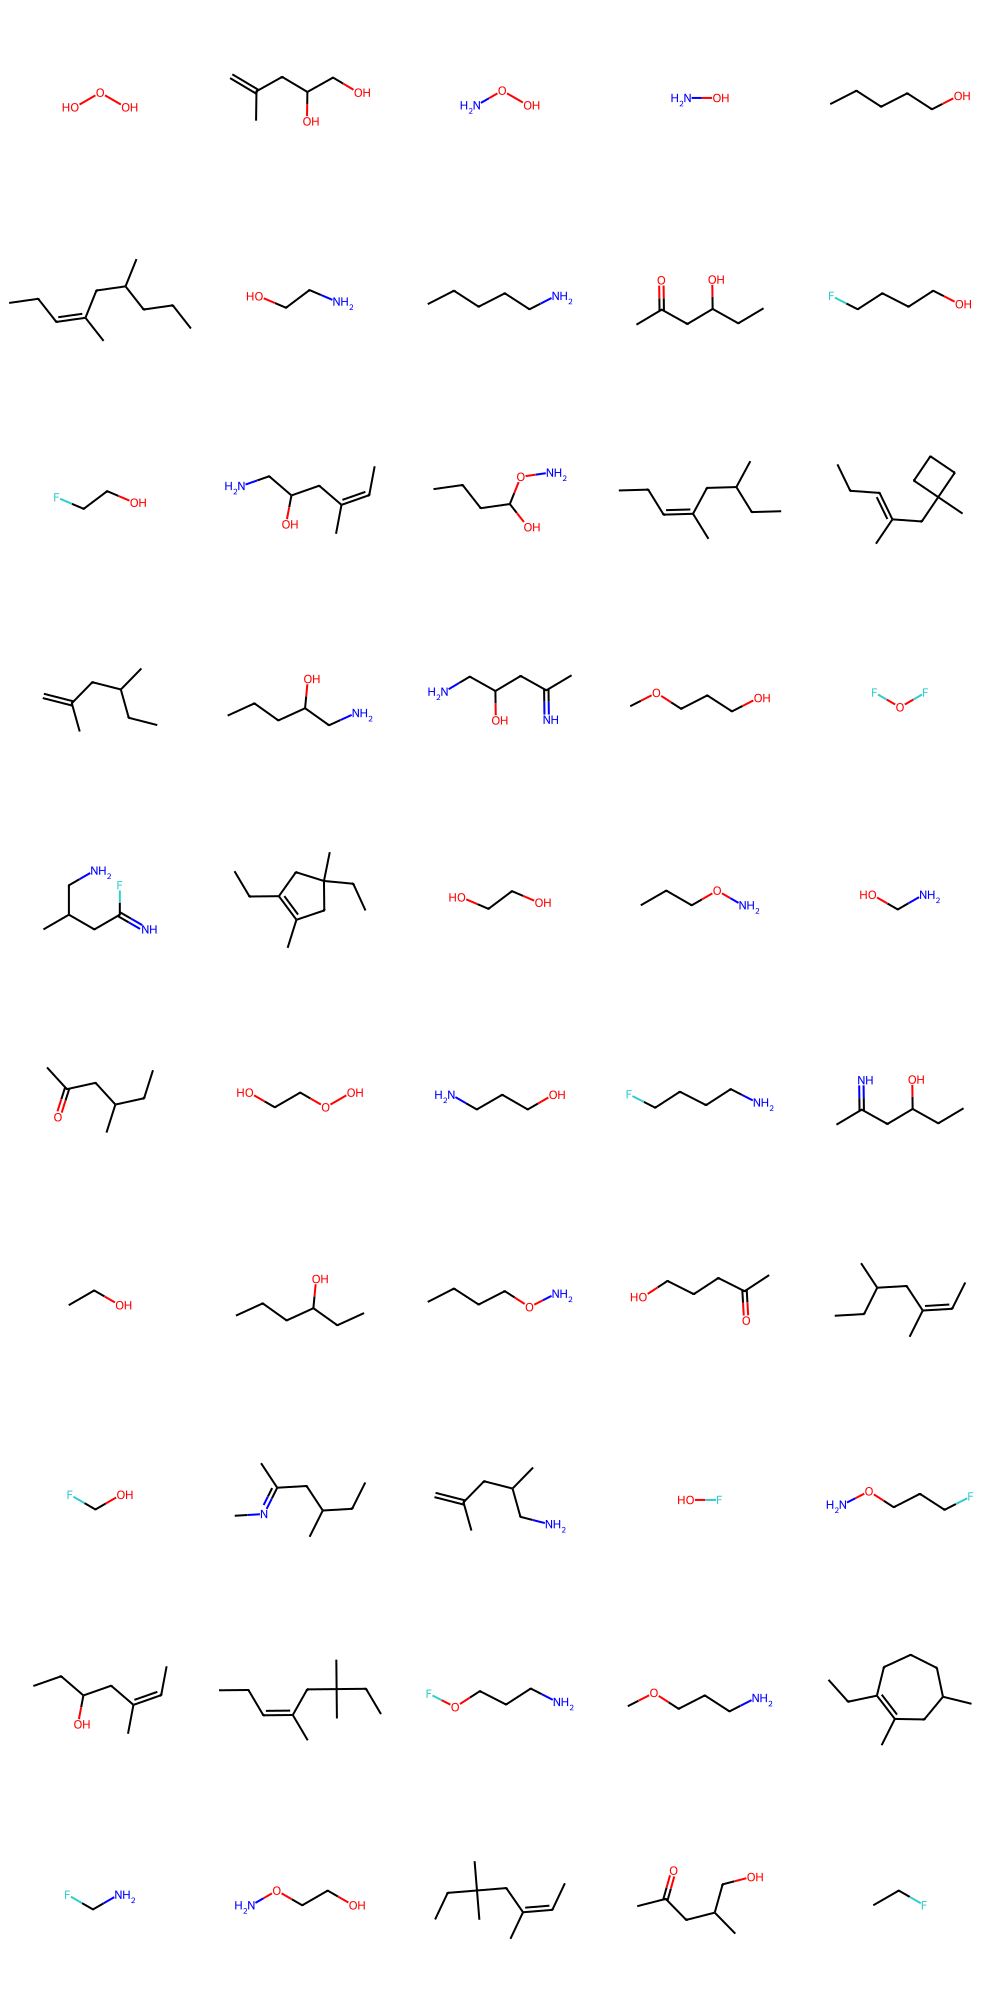

In [311]:
Draw.MolsToGridImage(generated_smiles_viz, molsPerRow=5, subImgSize=(200, 200), returnPNG=False)